In [1]:
%cd dialogue_sim

/home/kirill/Desktop/DGAC/dialogue_sim


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from subgraph.datasets import multiwoz
from minicache import cached_step, init, MetadataStorage, Cache
from dialogue_sim.utils import plot_pairwaise_class
import numpy as np
import seaborn as sns
import scipy

sns.set_theme(style = 'darkgrid', font_scale = 1.5)
init(meta=MetadataStorage(), cache=Cache())

Cache for init not found, caclulating...
Done


In [4]:
import pickle

with open("data/mwtrain_sbert.pkl", "rb") as file:
    train_dials = pickle.load(file)

with open("data/mwtest_sbert.pkl", "rb") as file:
    test_dials = pickle.load(file)

num_clusters = 61

In [5]:
def get_sim_matrix(dial1, dial2):
    return dial1.lm_embeddings @ dial2.lm_embeddings.T

def opt_match_score(dial1, dial2):
    matrix = get_sim_matrix(dial1, dial2)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(matrix, maximize = True)
    return matrix[row_ind, col_ind].mean()

def diag_score(dial1, dial2):
    return np.diag(get_sim_matrix(dial1, dial2)).mean()

opt_match_score(train_dials[0], train_dials[1])

0.4063665

In [6]:
def select_similar(target_dial, dials, metric, thresh):
    res = []
    for i, dial in enumerate(dials):
        sim = metric(target_dial, dial)
        if sim > thresh:
            res.append(i)
    return np.array(res)

In [9]:
%cd ..

/home/kirill/Desktop/DGAC


In [10]:
with open("dialogue_sim/graphs/one_serv_sbert_10.pkl", 'rb') as file:
    graph = pickle.load(file)

In [18]:
train, test = multiwoz()

Cache for multiwoz not found, caclulating...
Loading test part of MultiWOZ from /home/kirill/Desktop/DGAC/multiwoz/data/MultiWOZ_2.2
Loading train part of MultiWOZ from /home/kirill/Desktop/DGAC/multiwoz/data/MultiWOZ_2.2
Done


In [19]:
from embedders import CachedEmbeddings
from dgac import dgac_two_stage

EMB_PATH = 'embeddings/multiwoz/sentence_bert_{split}_embeddings.npy'
CONV_EMB_PATH = 'embeddings/multiwoz/{split}_convert_context.np.npy'

train_emb = np.load(EMB_PATH.format(split = 'train'))
test_emb = np.load(EMB_PATH.format(split = 'test'))

conv_train_emb = np.load(CONV_EMB_PATH.format(split = 'train'))
conv_test_emb = np.load(CONV_EMB_PATH.format(split = 'test'))

embedder = CachedEmbeddings(
    dialogues=train,
    embeddings=train_emb,
    test_dialogues=test,
    test_embeddings=test_emb
)
conv_embedder = CachedEmbeddings(
    dialogues= train,
    embeddings= conv_train_emb,
    test_dialogues= test,
    test_embeddings= conv_test_emb
)

In [20]:
from dialogue_sim.dialogue_data import DialogueData

train_dials = [DialogueData(d, train, train_emb, graph) for d in train]
test_dials = [DialogueData(d, test, test_emb, graph) for d in test]

In [21]:
sim_idxs = select_similar(train_dials[0], test_dials, opt_match_score, 0.39)
sim_dials = [test_dials[idx] for idx in sim_idxs]

In [22]:
test_dials[0]

DialogueData()

In [23]:
def count_cluster_matches(dial):
    matches = 0
    for i in range(len(dial.second_stage_clusters) - 1):
        cur_cluster = dial.second_stage_clusters[i]
        next_cluster = dial.second_stage_clusters[i+1]
        predicted_cluster = np.argmax(dial.transitions[cur_cluster])
        matches += 1 if predicted_cluster == next_cluster else 0
    return matches

def estimate_cluster_accuracy(data):
    matches = 0
    total_len = 0
    for dial in data:
        total_len += len(dial.second_stage_clusters)
        matches += count_cluster_matches(dial) + 1
    return matches / total_len

def estimate_graph_acc(select_func, graph):
    with open(f"dialogue_sim/graphs/{graph}.pkl", "rb") as file:
        graph = pickle.load(file)
    dials = [DialogueData(d, test, test_emb, graph) for d in test]
    selected_dials = [d for d in dials if select_func(d)]
    return estimate_cluster_accuracy(selected_dials)

def select_service(data, service = 'train'):
    res =  []
    for i, dial in enumerate(data):
        if service in dial.meta['services']:
            res.append(i)
    return np.array(res)

estimate_cluster_accuracy(test_dials)

0.4633071079761259

In [24]:
res = {}
for graph in ["one_serv_sbert_10", "graph_2_10_sbert", "graph_2_10_bert", "selected_sbert_10"]:
    res[graph] = estimate_graph_acc(lambda x : True, graph)
res

{'one_serv_sbert_10': 0.4633071079761259,
 'graph_2_10_sbert': 0.5759631036353771,
 'graph_2_10_bert': 0.6241861096039066,
 'selected_sbert_10': 0.6258817145957678}

In [25]:
res = {}
for graph in ["one_serv_sbert_10", "graph_2_10_sbert", "selected_sbert_10"]:
    res[graph] = estimate_graph_acc(lambda x : "taxi" in x.services, graph)
res

{'one_serv_sbert_10': 0.5661157024793388,
 'graph_2_10_sbert': 0.5057215511760966,
 'selected_sbert_10': 0.573744437380801}

In [26]:
services = set()
for d in test:
    services = services.union(d.meta['services'])

res = {}
for service in services:
    res[service] = estimate_graph_acc(lambda x : service in x.services, "graph_2_10_sbert")
res

{'taxi': 0.5057215511760966,
 'attraction': 0.5220775095298602,
 'train': 0.6172122492080253,
 'restaurant': 0.5550204319906596,
 'hotel': 0.5778089013383131}

In [28]:
def select_from_service(service, k = 3):
    res = []
    for d in test_dials:
        if service in d.services:
            res.append(d)
        if len(res) >= k:
            return res
    return res

In [29]:
def avg_metric(target_dials, dial):
    metrics = [opt_match_score(td, dial) for td in target_dials]
    return np.array(metrics).mean()

Cache for init not found, caclulating...
Done
Cache for multiwoz not found, caclulating...
Loading test part of MultiWOZ from /home/kirill/Desktop/DGAC/multiwoz/data/MultiWOZ_2.2
Loading train part of MultiWOZ from /home/kirill/Desktop/DGAC/multiwoz/data/MultiWOZ_2.2
Done


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1463 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/1463 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


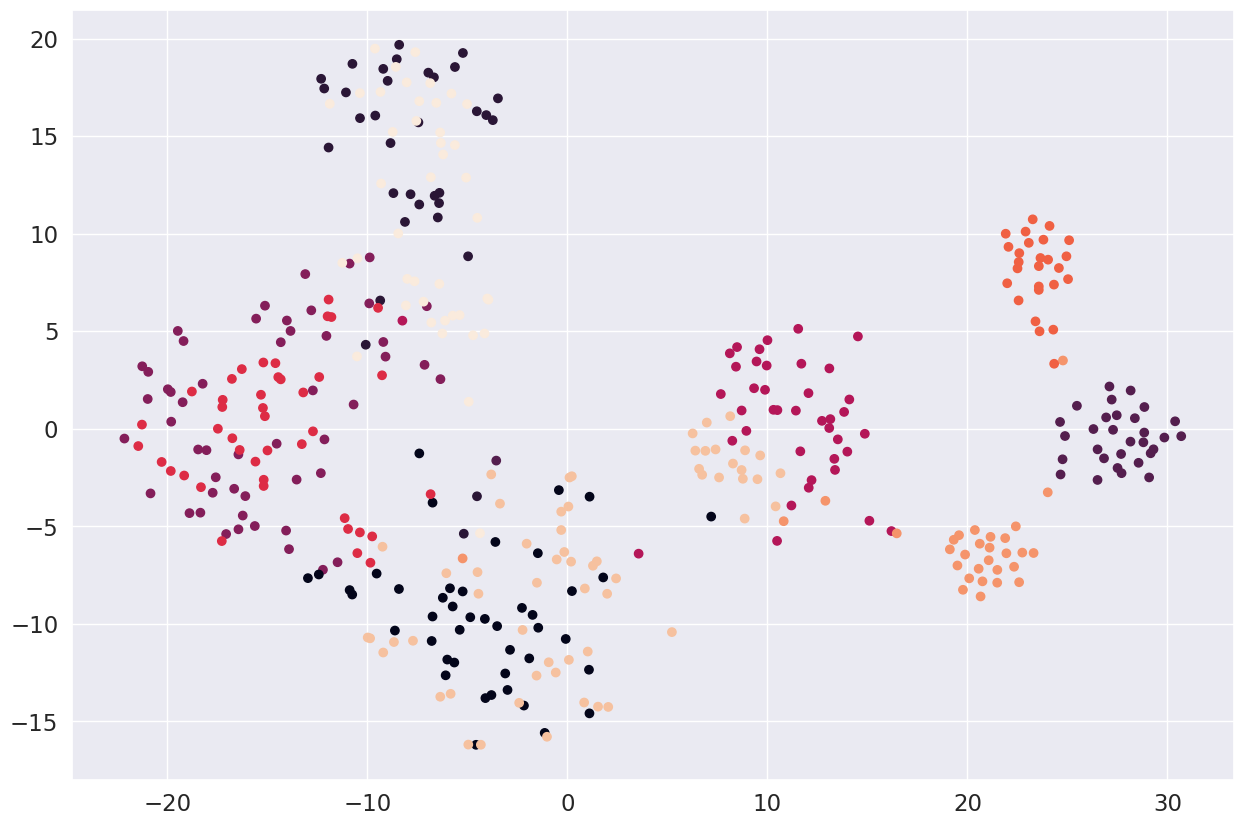

  0%|          | 0/6260 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/6260 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

  0%|          | 0/1408 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


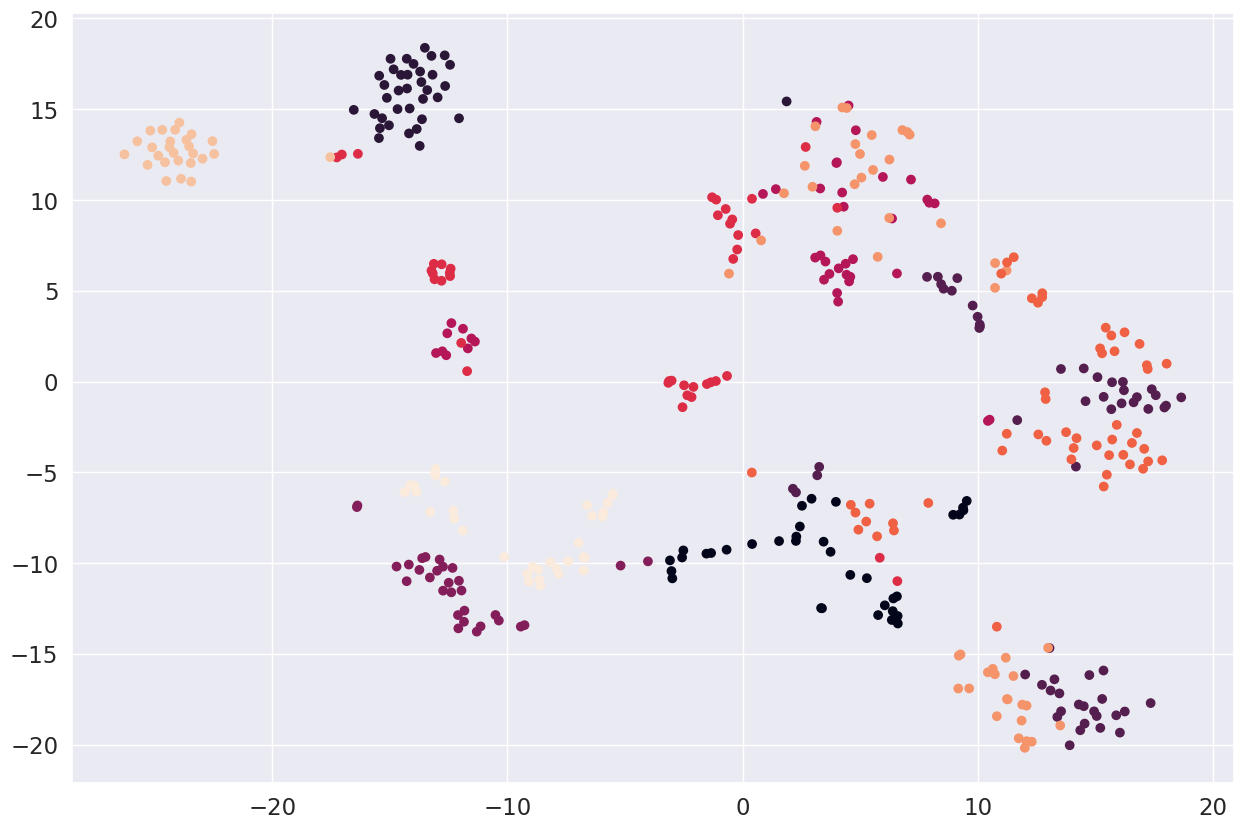

  0%|          | 0/2681 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/2681 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

  0%|          | 0/643 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


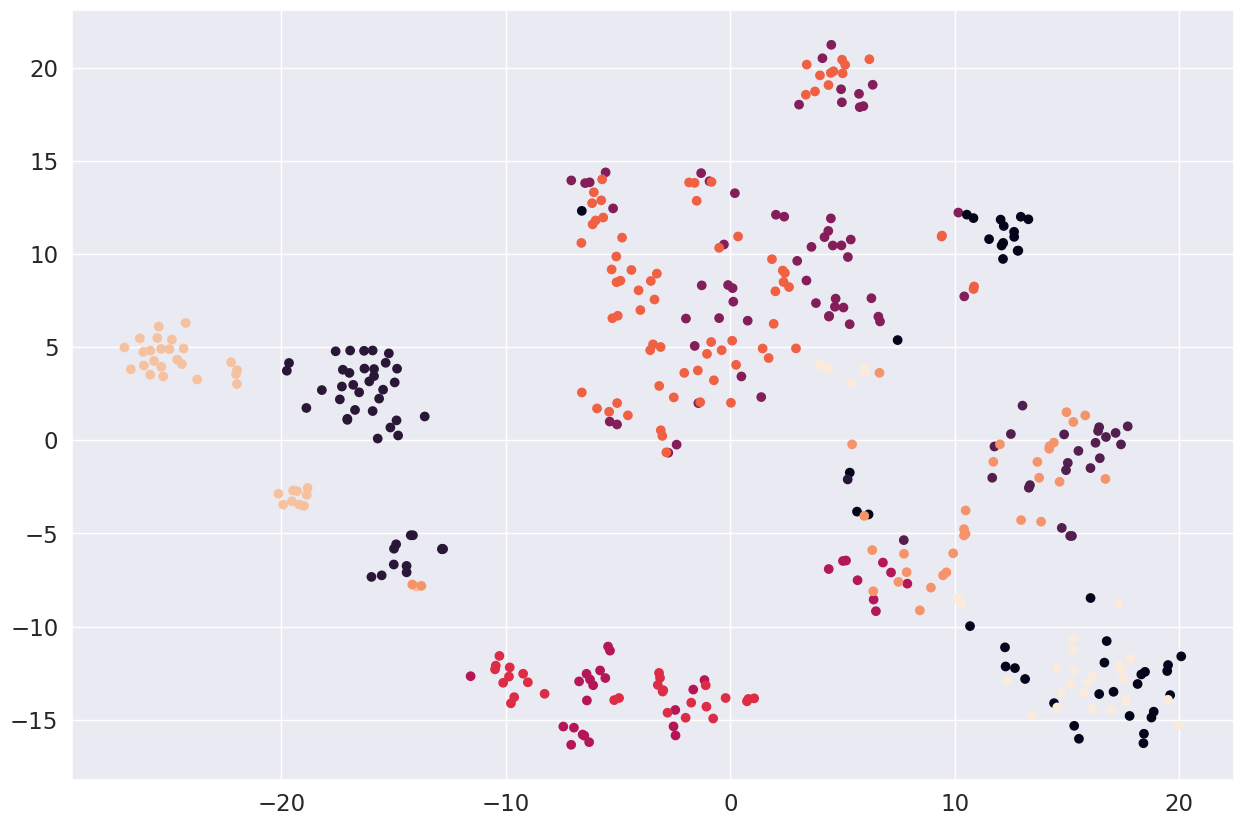

  0%|          | 0/5361 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/5361 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


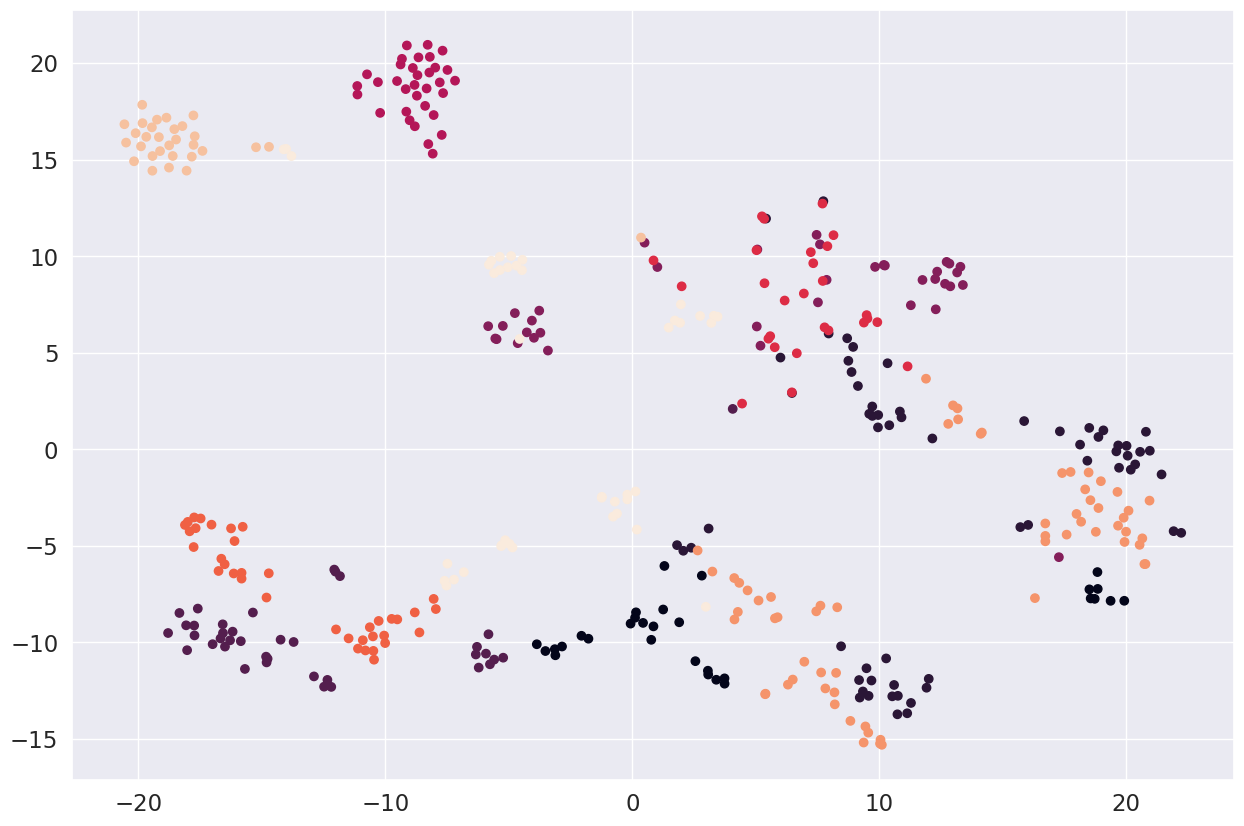

  0%|          | 0/2963 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/2963 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


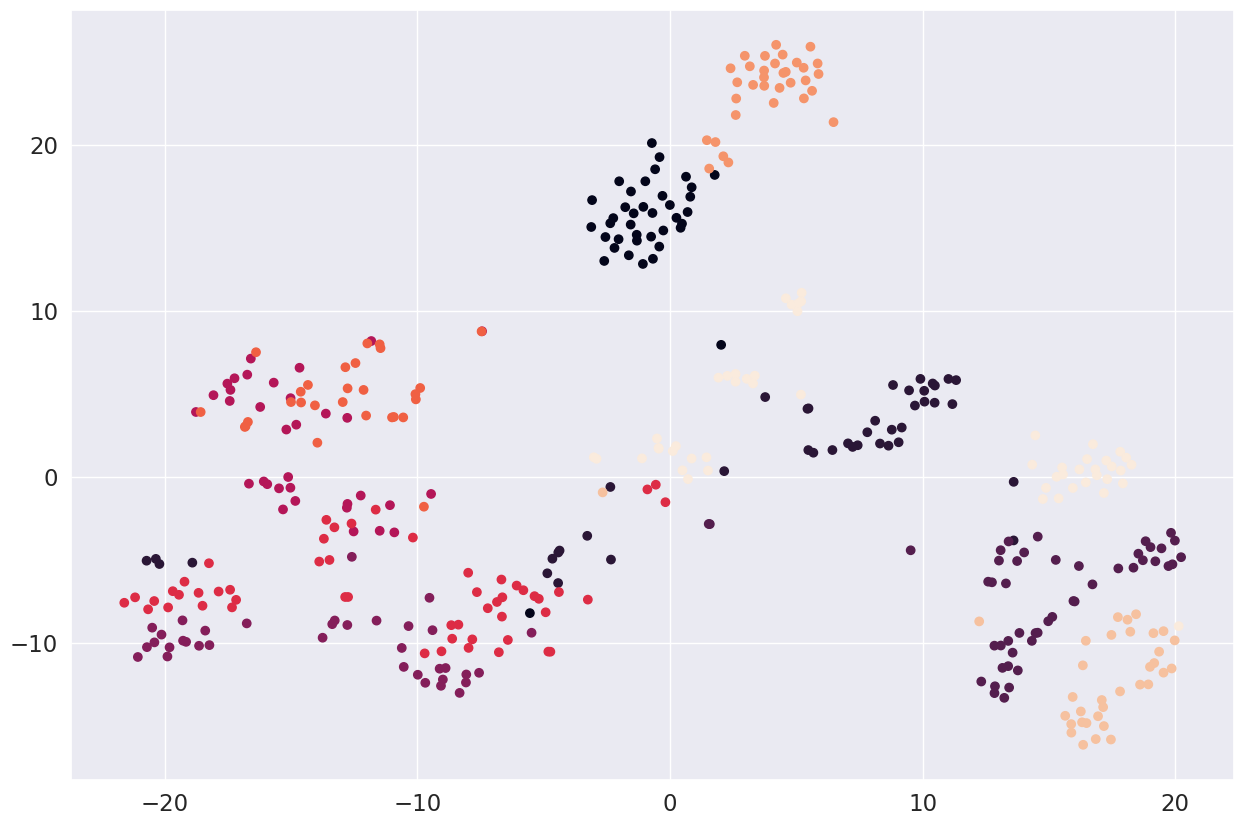

  0%|          | 0/5760 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/5760 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


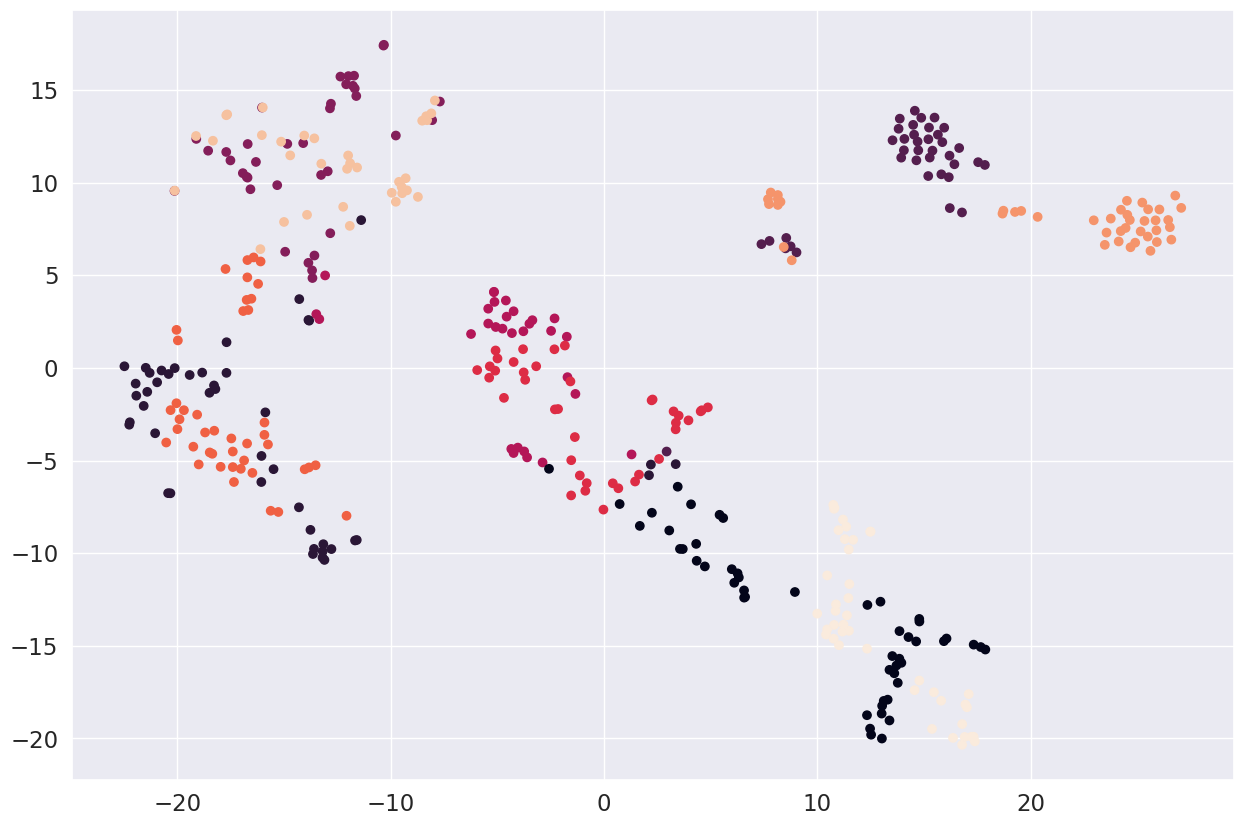

  0%|          | 0/3836 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/3836 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

  0%|          | 0/851 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


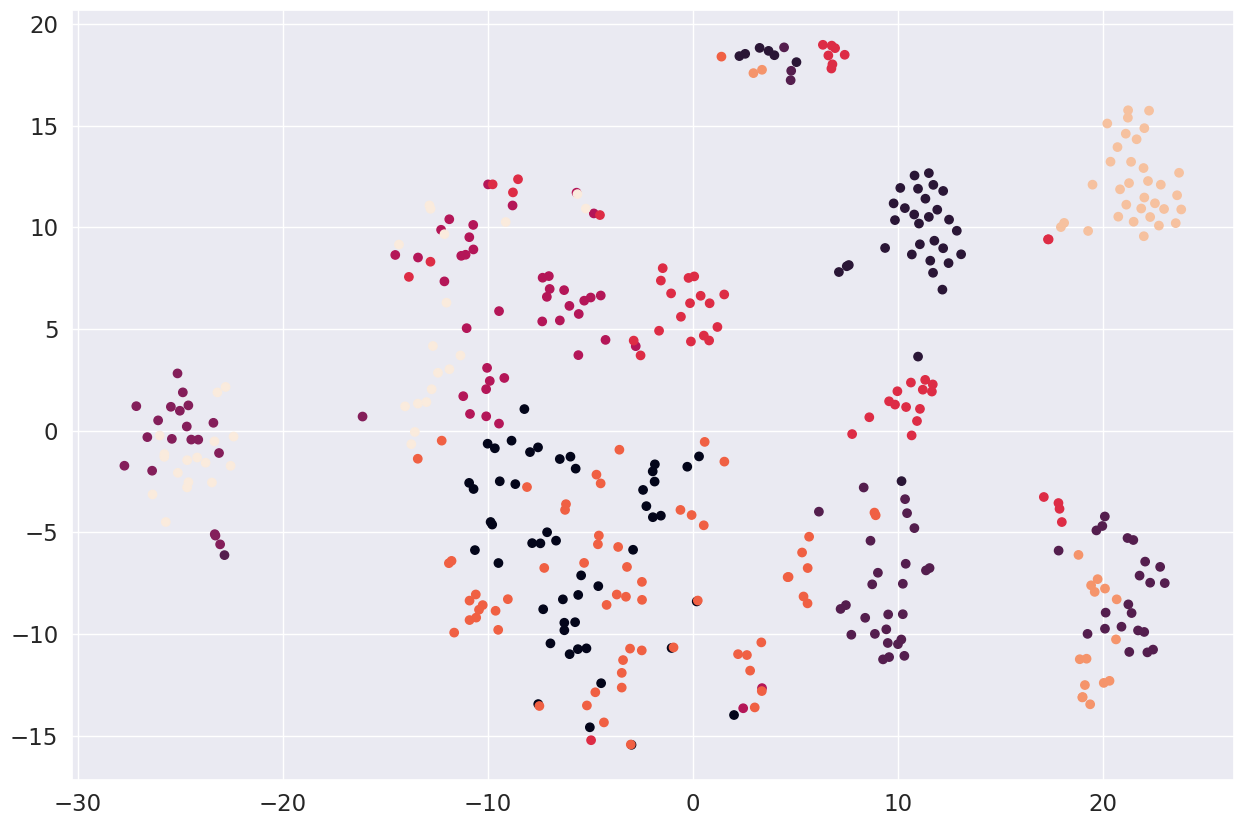

  0%|          | 0/7360 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/7360 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

  0%|          | 0/1558 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


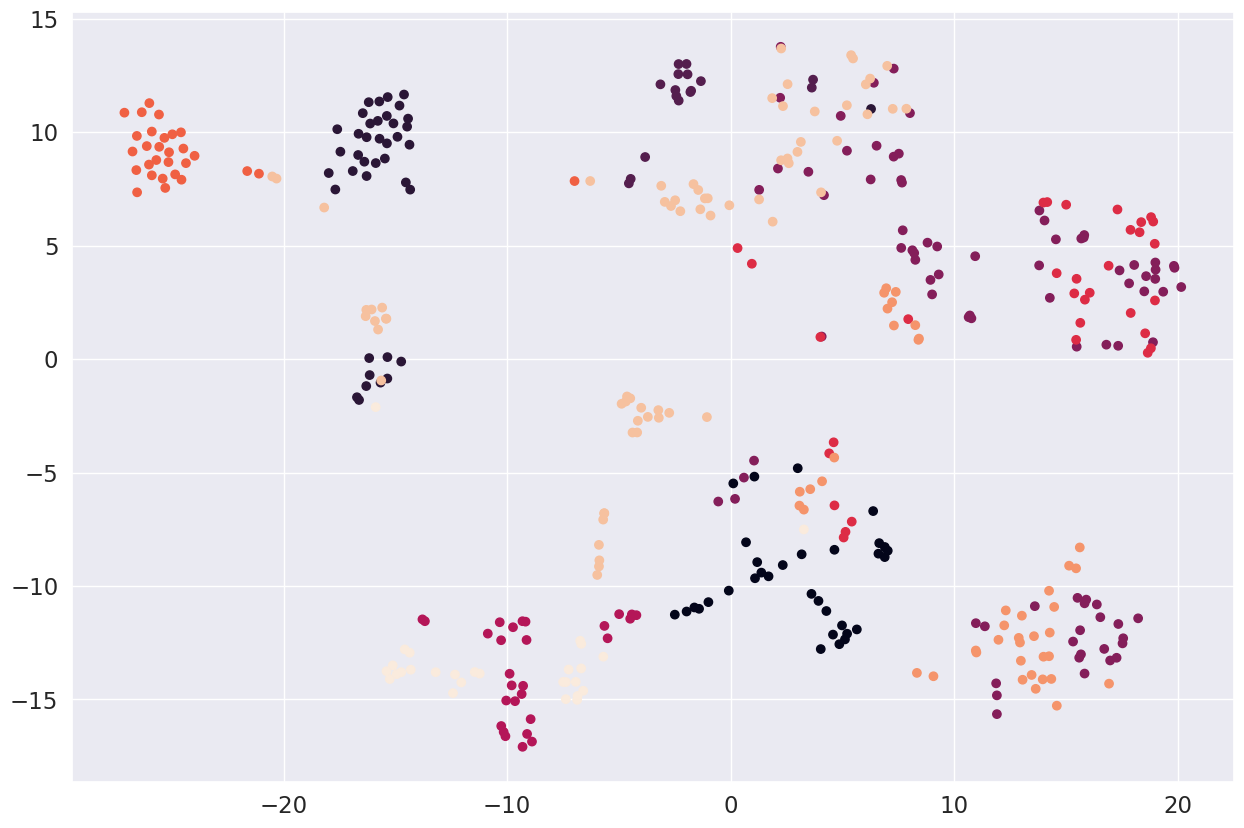

  0%|          | 0/3369 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/3369 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

  0%|          | 0/839 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


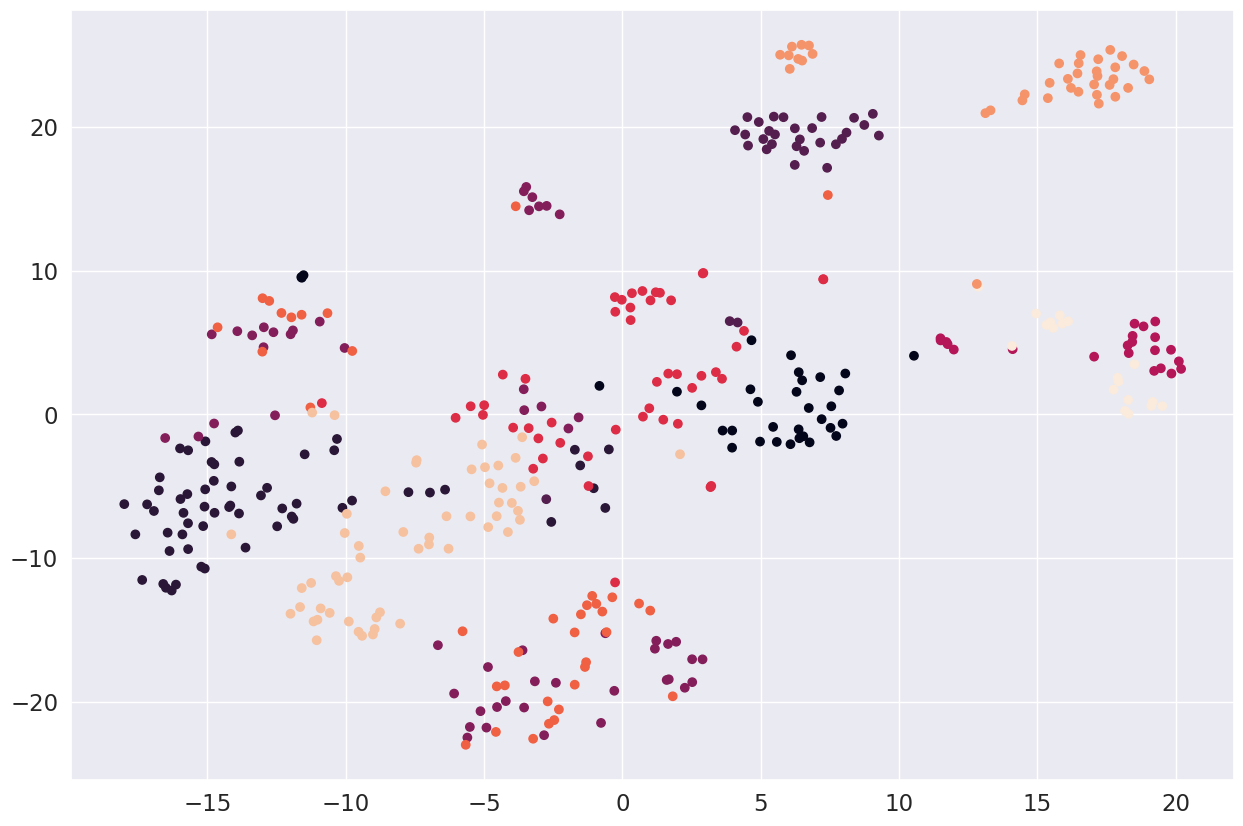

  0%|          | 0/7477 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

In [31]:
from tqdm.notebook import tqdm
from graph_train import *

final = {}
for service in tqdm(services):
    train_graph(lambda x : service in x.services, f"one_serv_10_{service}")
    dials_from_serv = select_from_service(service)
    train_graph(lambda x : avg_metric(dials_from_serv, x) > 0.4, f"selected_10_{service}")
    res = {}
    res['full_train_full_test'] = estimate_graph_acc(lambda x : True, "graph_2_10_sbert")
    res['one_serv_train_full_test'] = estimate_graph_acc(lambda x : True, f"one_serv_10_{service}")
    res['selected_train_full_test'] = estimate_graph_acc(lambda x : True, f"selected_10_{service}")

    res['full_train_serv_test'] = estimate_graph_acc(lambda x : service in x.services, "graph_2_10_sbert")
    res['one_serv_train_serv_test'] = estimate_graph_acc(lambda x : service in x.services, f"one_serv_10_{service}")
    res['selected_train_serv_test'] = estimate_graph_acc(lambda x : service in x.services, f"selected_10_{service}")
    final[service] = res

  0%|          | 0/8437 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/8437 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

  0%|          | 0/1775 [00:00<?, ?it/s]

/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kirill/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


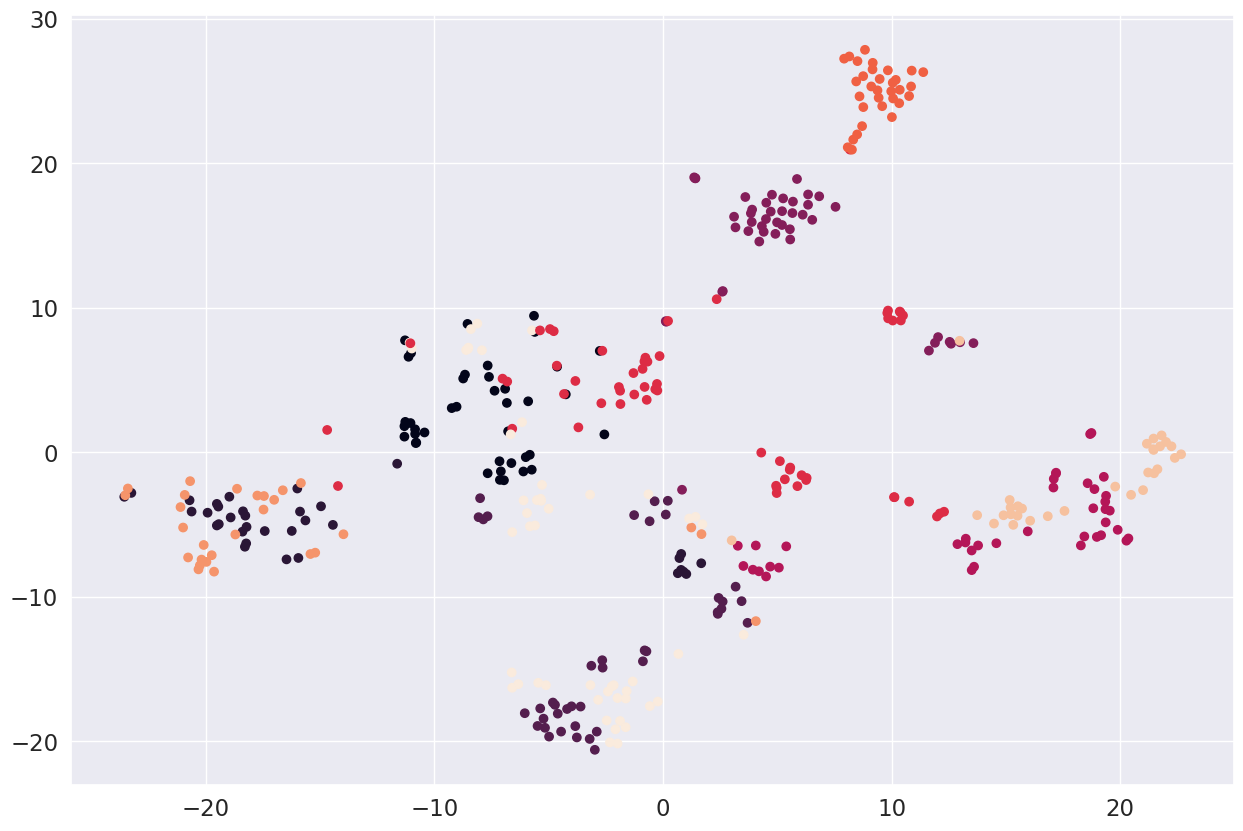

In [ ]:
train_graph(lambda x : True, 5, "graph_2_10_bert")